In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import optimizers

In [2]:
# Load the dataset
data = pd.read_csv("data_after_EDA.csv")
nlp_data = pd.read_csv('updated_dataset.csv', usecols=['Main Diagnosis'] + ['word_' + str(i) for i in range(100)])

# Display the first few rows to understand the structure
print(data.head())
print(nlp_data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

          Arrival Time Severity Level           Deparment  \
0  2023-12-13 13:17:48        Level Ⅳ  Emergency Medicine   
1  2023-12-08 10:59:28        Level Ⅲ  Emergency Medicine   
2  2023-11-05 14:03:02        Level Ⅲ  Emergency Medicine   
3  2023-10-07 22:57:41        Level Ⅲ  Emergency Medicine   
4  2023-10-21 21:32:17        Level Ⅳ  Emergency Medicine   

                                   Main Diagnosis       Discharge Time  \
0                               Pain, unspecified  2023-12-13 16:43:00   
1   

In [3]:
print(data.columns)

Index(['ROWNUM', 'Hospital', 'Eligibility Class', 'Gender', 'Arrival Time',
       'Severity Level', 'Deparment', 'Main Diagnosis', 'Discharge Time',
       'Waiting Time (Minutes)', 'Length of Stay (Minutes)',
       'Treatment Time(Minutes)', 'Cluster', 'No Treatment'],
      dtype='object')


In [4]:
# Drop the 'Main Diagnosis' column
data.drop(columns=['Main Diagnosis','Discharge Time'], inplace=True)

# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])

# Extract hour from Arrival Time
data['Hour'] = data['Arrival Time'].dt.hour

print(data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

         Arrival Time Severity Level           Deparment  \
0 2023-12-13 13:17:48        Level Ⅳ  Emergency Medicine   
1 2023-12-08 10:59:28        Level Ⅲ  Emergency Medicine   
2 2023-11-05 14:03:02        Level Ⅲ  Emergency Medicine   
3 2023-10-07 22:57:41        Level Ⅲ  Emergency Medicine   
4 2023-10-21 21:32:17        Level Ⅳ  Emergency Medicine   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    191.0  

In [5]:
# Combine the data with the NLP data
combined_data = data.join(nlp_data, how='left')

In [6]:
# Generate list of NLP feature columns
feature_columns = ['word_' + str(i) for i in range(100)]
feature_columns += ['Waiting Time (Minutes)', 'Length of Stay (Minutes)','Hour']  # Add other numerical features

# Fill missing values with 0 before scaling
combined_data[feature_columns] = combined_data[feature_columns].fillna(0)

# Scale features to [0, 1] - important for neural network models
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])

# Autoencoder

In [7]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42, shuffle=True)

In [8]:
# Build the Autoencoder Model

# Define the autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer) #16
encoded = Dense(64, activation='relu')(encoded) #8

# Decoder
# decoded = Dense(input_dim, activation='sigmoid')(encoded)
decoded = Dense(128, activation='relu')(encoded) #16
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
from tensorflow.keras.optimizers import Adam

autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [9]:
# Train the autoencoder
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/50
304/304 [==============================] - 2s 4ms/step - loss: 0.1188 - val_loss: 0.0269
Epoch 2/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0200
Epoch 3/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 4/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 5/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 6/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 7/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 8/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 9/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 10/50
304/304 [==============================] - 1s 3ms/step - loss: 0.0082 - val_loss: 0.0082

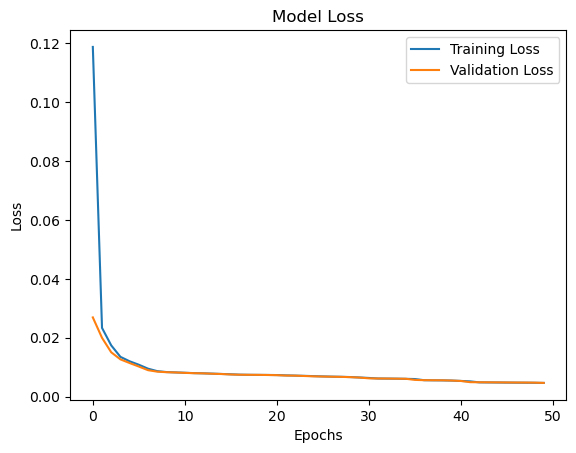

In [10]:
# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

607/607 [==============================] - 1s 876us/step


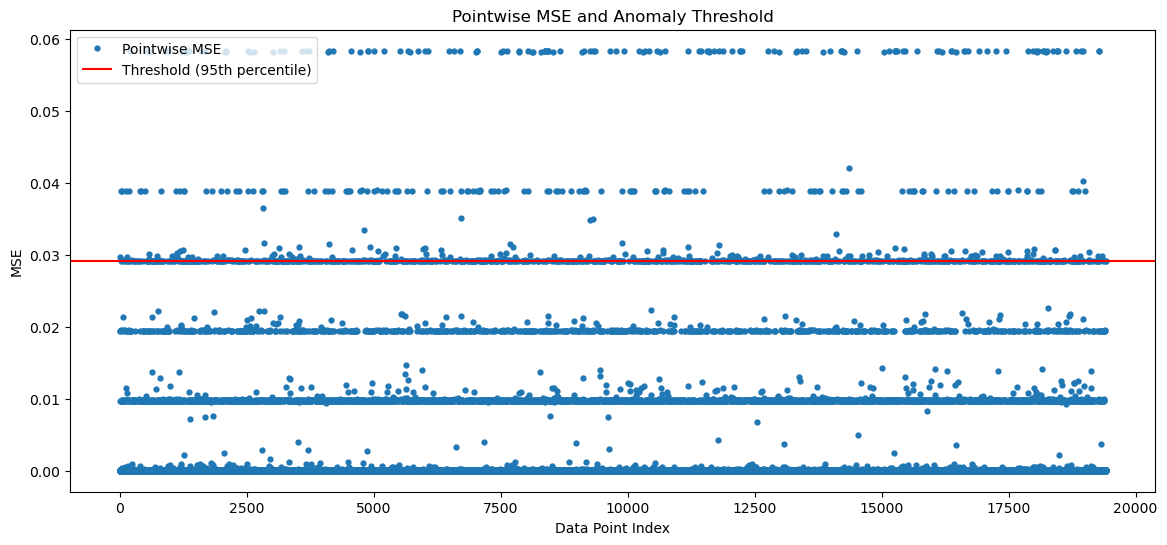

In [11]:
# Detect Anomalies Using Reconstruction Error

# Get the reconstruction loss on the test set
predictions = autoencoder.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Set a threshold for anomaly detection
mse_threshold = np.quantile(mse, 0.95) 

# Mark data points with errors above the threshold as anomalies
outliers = mse > mse_threshold

# Plot the pointwise MSE and the anomaly threshold
plt.figure(figsize=(14, 6))
plt.plot(mse, marker='o', ms=3.5, linestyle='', label='Pointwise MSE')
plt.axhline(y=mse_threshold, color='r', linestyle='-', label='Threshold (95th percentile)')
plt.title('Pointwise MSE and Anomaly Threshold')
plt.xlabel('Data Point Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [12]:
# Find the indices of the anomalies
anomaly_indices = np.where(outliers)[0]

# Print details of the anomalies
print("Anomaly Indices:", anomaly_indices)
print("MSE:", mse[outliers])

Anomaly Indices: [    4    18    56    96   121   123   132   142   191   196   234   235
   277   285   310   320   378   400   403   424   464   505   543   545
   555   557   560   585   587   602   607   622   667   673   682   692
   732   736   771   775   814   839   857   904   933   950   969  1025
  1065  1079  1119  1121  1122  1182  1189  1191  1194  1225  1235  1249
  1255  1260  1268  1305  1311  1320  1337  1338  1344  1375  1393  1409
  1427  1454  1480  1493  1525  1544  1561  1603  1611  1665  1679  1698
  1702  1827  1844  1886  1888  1911  1927  1989  2009  2015  2028  2036
  2070  2081  2101  2103  2111  2127  2130  2165  2215  2221  2290  2294
  2318  2323  2338  2351  2355  2378  2384  2431  2437  2459  2470  2526
  2535  2568  2579  2630  2653  2681  2714  2734  2776  2811  2814  2821
  2835  2842  2849  2881  2885  2914  2938  2941  3000  3023  3027  3030
  3039  3115  3129  3143  3152  3153  3164  3168  3186  3195  3209  3221
  3223  3242  3262  3276  3303  33

In [13]:
# Display the features of the anomalies
if len(anomaly_indices) > 0:
    anomalous_data = combined_data.iloc[anomaly_indices]
    print("\nAnomalies Features:")
    print(anomalous_data)



Anomalies Features:
       ROWNUM                                  Hospital Eligibility Class  \
4           5  Royal Commission Health Services Program  ROYAL COMMISSION   
18         19  Royal Commission Health Services Program            EXEMPT   
56         57  Royal Commission Health Services Program            EXEMPT   
96         97  Royal Commission Health Services Program  ROYAL COMMISSION   
121       122  Royal Commission Health Services Program            EXEMPT   
...       ...                                       ...               ...   
19284  19,287  Royal Commission Health Services Program            EXEMPT   
19289  19,292  Royal Commission Health Services Program            EXEMPT   
19334  19,337  Royal Commission Health Services Program  ROYAL COMMISSION   
19363  19,366  Royal Commission Health Services Program              CASH   
19408  19,411  Royal Commission Health Services Program            EXEMPT   

       Gender        Arrival Time Severity Level      

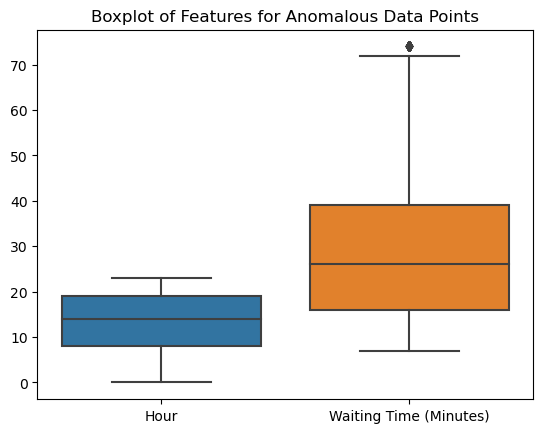

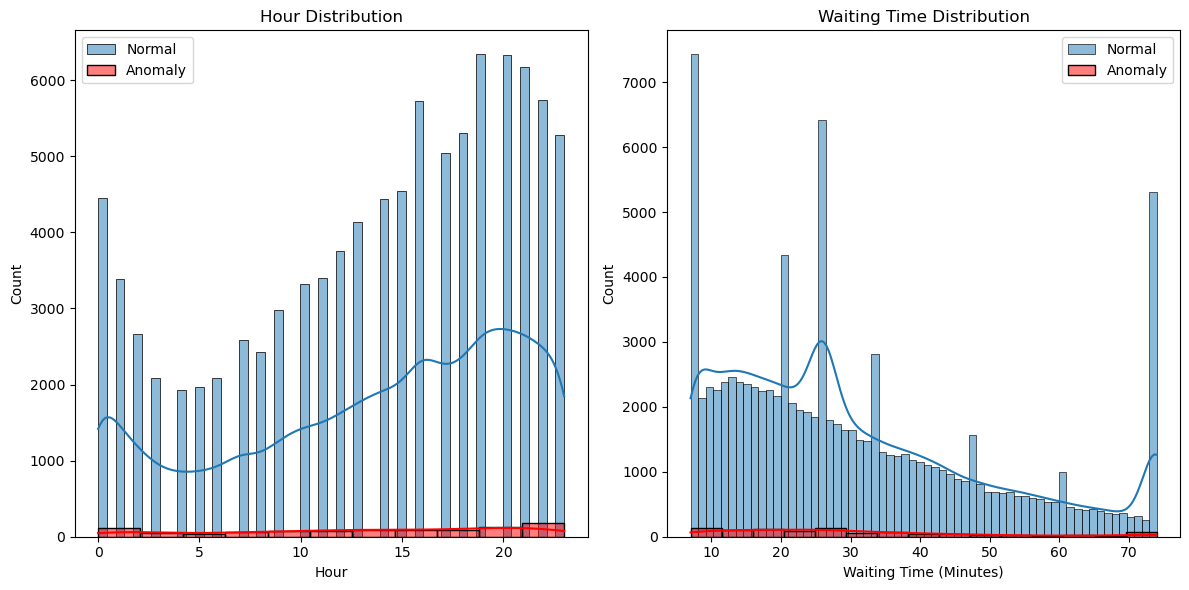

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize some features of the anomalous data points
sns.boxplot(data=anomalous_data[['Hour','Waiting Time (Minutes)']])
plt.title('Boxplot of Features for Anomalous Data Points')
plt.show()

# Compare the distribution of features for anomalous and non-anomalous data points
normal_data = combined_data.drop(anomaly_indices)  # Drop the anomalies
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(normal_data['Hour'], ax=ax[0], kde=True, label='Normal')
sns.histplot(anomalous_data['Hour'], ax=ax[0], kde=True, color='red', label='Anomaly')
ax[0].set_title('Hour Distribution')
ax[0].legend()

sns.histplot(normal_data[ 'Waiting Time (Minutes)'], ax=ax[1], kde=True, label='Normal')
sns.histplot(anomalous_data[ 'Waiting Time (Minutes)'], ax=ax[1], kde=True, color='red', label='Anomaly')
ax[1].set_title('Waiting Time Distribution')
ax[1].legend()

plt.tight_layout()
plt.show()

d:\Anaconda3\envs\prmls_new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


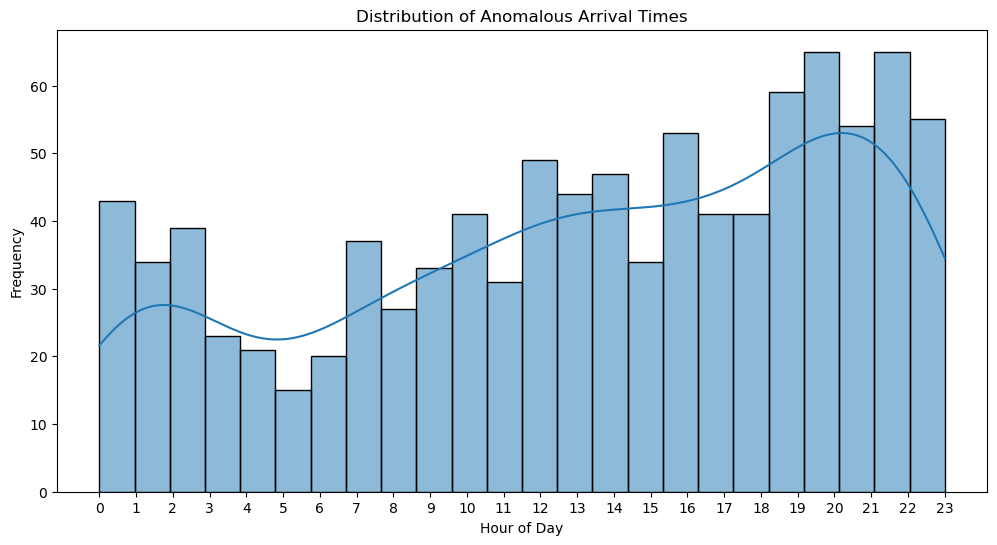

In [19]:
# Visualize the distribution of anomalous arrival times
plt.figure(figsize=(12, 6))
anomalous_data['Hour'] = anomalous_data['Arrival Time'].dt.hour
sns.histplot(anomalous_data['Hour'], bins=24, kde=True)
plt.title('Distribution of Anomalous Arrival Times')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.show()

In [26]:
# Visualize the frequency of main diagnosis for anomalies
plt.figure(figsize=(100, 100))
sns.countplot(y='Main Diagnosis', data=anomalous_data)
plt.title('Frequency of Main Diagnosis for Anomalies')
plt.xlabel('Count')
plt.ylabel('Main Diagnosis')
plt.show()

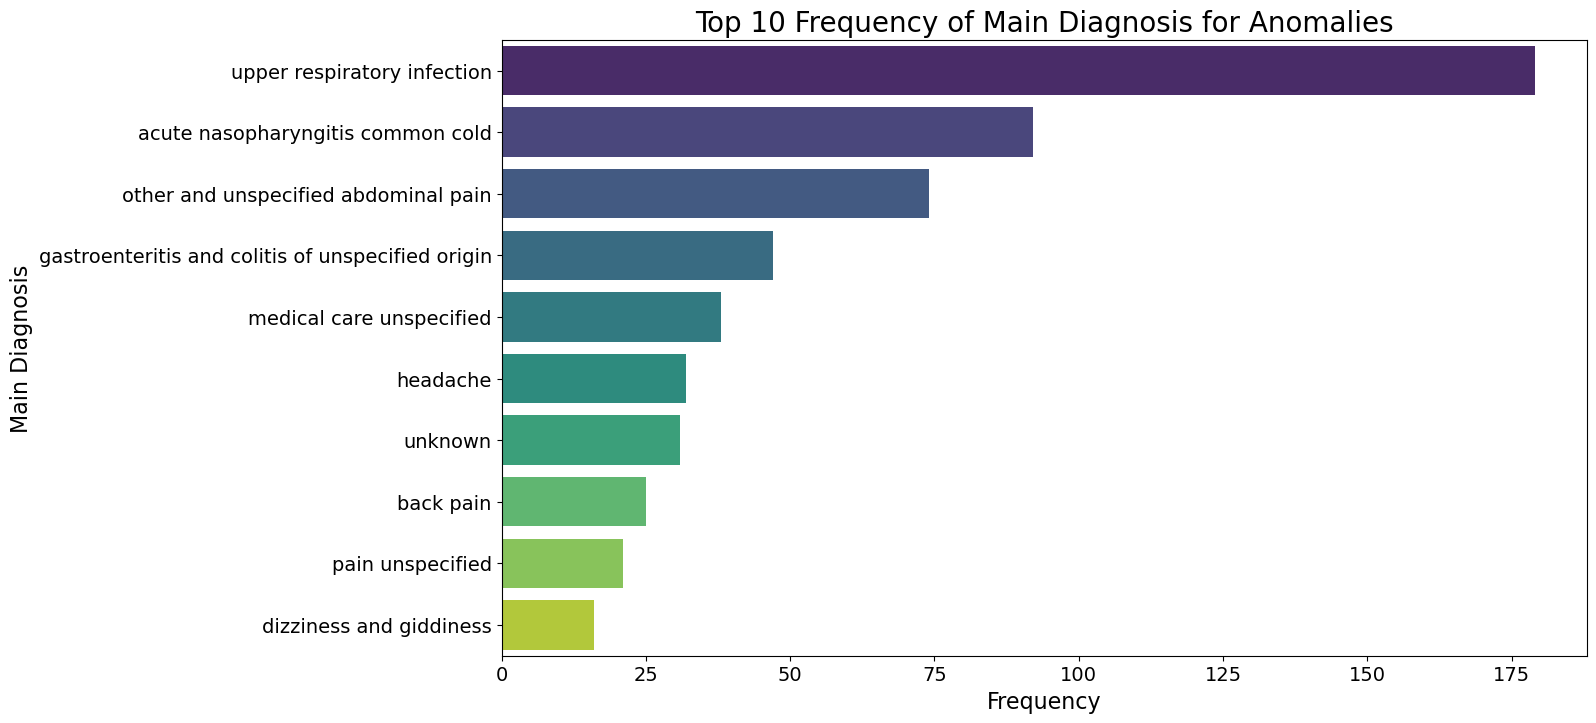

In [28]:
# Caculate the frequency of diagnoses and sort the top 10
diagnosis_counts = anomalous_data['Main Diagnosis'].value_counts().nlargest(10)

# Plot the frequency of the top 10 diagnoses
plt.figure(figsize=(14, 8))
sns.barplot(y=diagnosis_counts.index, x=diagnosis_counts.values, palette='viridis')

plt.title('Top 10 Frequency of Main Diagnosis for Anomalies', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Main Diagnosis', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Done


# Isolation Forest

## Still working on it

In [ ]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit the model to the data
iso_forest.fit(scaled_features)

# Predict anomalies (-1 means anomaly, 1 means normal)
predictions = iso_forest.predict(scaled_features)

# Add predictions to the original data (for easier analysis)
data['anomaly'] = predictions

# Display the count of anomalies detected
print("Anomalies detected:", np.sum(predictions == -1))


In [ ]:
# Filter the data to show only the anomalies
anomalies = data[data['anomaly'] == -1]

# Display the first few anomalies
print("Anomalous Data:")
print(anomalies.head())

In [ ]:
# Visualizing using two features for simplicity (Length of Stay and Waiting Time)
plt.figure(figsize=(10, 6))
plt.scatter(data['Length of Stay (Minutes)'], data['Waiting Time (Minutes)'], 
            c=data['anomaly'], cmap='coolwarm', marker='o')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Length of Stay (Minutes)')
plt.ylabel('Waiting Time (Minutes)')
plt.show()